In [1]:
import os, sys
import healpy as hp
import numpy as np

In [2]:
sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')

In [3]:
import esutil
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils import *

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
os.chdir('../../DMASS-analysis/measurements/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [6]:
from calling_catalogs import *

In [7]:
rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'

In [8]:
from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

In [22]:
def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
#   dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    randoms = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT_SYS']
    print ('Calculatig DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    print ('randoms=', randoms.size)
    return dmass, randoms

In [21]:
y1_dmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
print(y1_dmass.dtype.names)

('COADD_OBJECTS_ID', 'RA', 'DEC', 'VETO', 'CMASS_PROB', 'WEIGHT_SYS')


In [23]:
lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
#lens, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200.fits')
'''Calling DMASS catalogs and corresponding randoms
Resulting catalog size
DMASS= 114623.04051867768
randoms= 20990512'''

Calculating DMASS systematic weights...
Calculatig DMASS systematic weights...
Resulting catalog size
DMASS= 114623.04051867768
randoms= 5864645


'Calling DMASS catalogs and corresponding randoms\nResulting catalog size\nDMASS= 114623.04051867768\nrandoms= 20990512'

In [13]:
# unneeded step

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [ ]:
# unneeded step

def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------
## generate randoms in a dmass region
random_create = uniform_random_on_sphere(lens, size = 50 * lens.size)
# applying LSS mask 
random_create = keepGoodRegion(random_create)

#mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)|(gold_st82['RA']<7)
#mask = mask & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
#gold_st82_train = gold_st82[mask]

In [24]:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

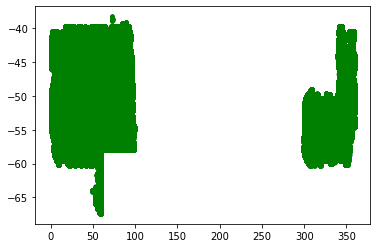

In [25]:
fig, ax = plt.subplots()
ax.plot( lens['RA'], lens['DEC'], "b.")
ax.plot(randoms['RA'], randoms['DEC'], "g.")

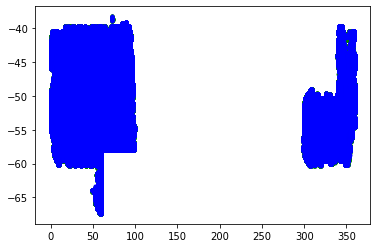

In [26]:
fig, ax = plt.subplots()
ax.plot(randoms['RA'], randoms['DEC'], "g.")
ax.plot( lens['RA'], lens['DEC'], "b.")

In [16]:
#randoms = appendColumn(randoms, value=np.ones(randoms.size), name='WEIGHT')

random_create = appendColumn(random_create, value=np.ones(random_create.size), name='WEIGHT')

In [17]:
randomsind = np.random.choice( randoms.size, size=int(randoms.size/3.) )
#np.savetxt( rootdir+'random_ind.txt', randomsind )
#randomsind = np.genfromtxt(rootdir+'random_ind.txt')
#randomsind = randomsind.astype(np.int)
randoms = randoms[randomsind]

In [18]:
randomsind_create = np.random.choice( random_create.size, size=int(random_create.size/3.) )
#np.savetxt( rootdir+'random_ind.txt', randomsind )
#randomsind = np.genfromtxt(rootdir+'random_ind.txt')
#randomsind = randomsind.astype(np.int)
random_create = random_create[randomsind_create]

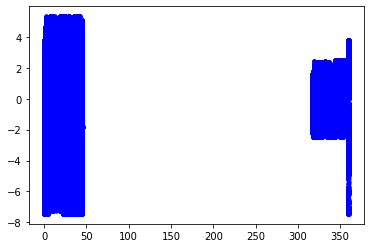

In [19]:
#real randoms over created
fig, ax = plt.subplots()
ax.plot( random_create['RA'], random_create['DEC'], "b.")
#ax.plot(randoms['RA'], randoms['DEC'], "g.")

In [20]:
# save the randoms. 
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_st82_DET200_randoms_train.fits', random_create, overwrite=True)

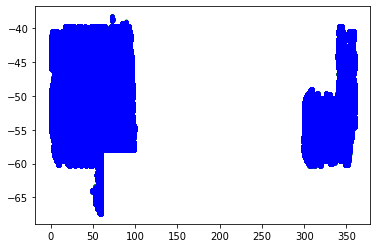

In [17]:
#created randoms over real
fig, ax = plt.subplots()
ax.plot( random_spt['RA'], random_spt['DEC'], "g.")
ax.plot(randoms['RA'], randoms['DEC'], "b.")

In [39]:
print(randoms.dtype.names)

('RA', 'DEC', 'VETO')


In [40]:
def treecorr_xi(lens, random=None, filename=None, rootdir=None, 
		nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.05, 
        npatch=10, var_method='jackknife', cen_file = None):
    
    import treecorr

    if cen_file != None:
        if os.path.exists(cen_file):
            print ('Saved cen_file exists:',cen_file)
            cen_file_switch_on = cen_file
            npatch=1
        else : 
            print ('Create cen_file=',cen_file)
            cen_file_switch_on = None

    #temp_dir=filename.split('.txt')[0]
    cat_l = treecorr.Catalog(ra=lens['RA'], dec=lens['DEC'], w=lens['WEIGHT'], 
                             ra_units='deg', dec_units='deg', npatch=npatch, 
                             patch_centers=cen_file_switch_on )

    if cen_file_switch_on == None : 
        cat_l.write_patch_centers(cen_file)
#changed to make weights = 1 for randoms
    #weights = np.zeros(len(randoms))
    
    cat_r = treecorr.Catalog(ra=random['RA'], dec=random['DEC'], w=random['VETO'], 
                             ra_units='deg', dec_units='deg', 
                             patch_centers=cen_file_switch_on )
    
    dd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                            max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                            var_method=var_method,
                            num_threads=30, verbose=1)
    dr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)

    dd.process(cat_l)
    dr.process(cat_l, cat_r)
    rd.process(cat_r, cat_l)
    rr.process(cat_r)
    xi,varxi = dd.calculateXi(rr,dr)
    dd.write(filename,rr,dr,rd)
    
    cov_jk = dd.estimate_cov(var_method)
    cov_filename=filename.split('.txt')[0]+'.cov'
    np.savetxt(cov_filename, cov_jk)
    
    print ('save to', filename)

In [41]:
npatch=80
tempdir = rootdir+'/{}/'.format(npatch)
cen_file = tempdir + 'nn_cen_file.txt'
filename = tempdir + 'nn.lens.txt'

#os.system('mkdir '+savedir)
#print (os.path.exists(tempdir) )
os.system('rm -rf '+tempdir)
os.system('mkdir '+tempdir)

treecorr_xi(lens, random=randoms,
        filename=filename, rootdir = tempdir, 
        nbins=20, min_sep=2.5, max_sep=250., sep_units='arcmin', bin_slop=0.05,
        npatch=npatch, cen_file=cen_file, var_method='jackknife', )

Create cen_file= /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn_cen_file.txt
save to /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn.lens.txt


In [42]:
cov_new= np.genfromtxt(tempdir+'/nn.lens.cov'.format(npatch))

In [43]:
_, meanr, _, galaxy_xi, xi_err,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens.txt'.format(npatch), unpack=True)

In [44]:
# save as an 2pt file
import fitsio
FITS_DMASS = fitsio.FITS('/users/PCON0003/warner785/DMASS-analysis/simulated_data/simulated_y1_dmass_3x2pt_neff_baseline_cov.fits')
cov = FITS_DMASS['COVMAT'].read()[480:, 480:]
theta= FITS_DMASS['galaxy_xi']['ANG'].read()
galaxy_xi_theory= FITS_DMASS['galaxy_xi']['VALUE'].read()

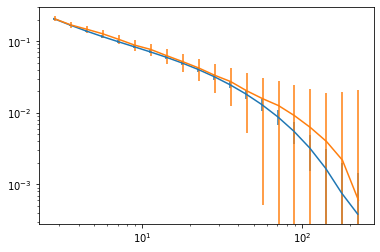

In [45]:
fig, ax = plt.subplots()

#ax.loglog(theta, galaxy_xi_theory)
ax.errorbar( theta, galaxy_xi_theory, np.sqrt(cov.diagonal()))
ax.errorbar( meanr, galaxy_xi, xi_err )
ax.set_xscale('log')
ax.set_yscale('log')

#write own jackknife errors -- for understanding and checking treecore's calculation
# what are the subsamples for the jackknife?
# size of ther jackknife patches versus the scales
# ex: bin size  == 20arcmin , not wanting jk = 100 patches in 20 arcmin, or too big--- 20 patches 
# use 20, 100 etc for jk size to check the errors for each choice

# check papers on jackknife? -- general range of reasonable choices for jk
# on Slack -- for an old but helpful paper
# plot fractional difference (orange/blue)

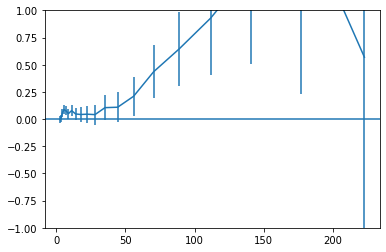

In [62]:
fig, ax = plt.subplots()
ax.errorbar( theta, galaxy_xi/galaxy_xi_theory - 1, np.sqrt(cov.diagonal())/galaxy_xi_theory)
ax.set_ylim(-1,1)
ax.axhline(y=0)

#prop. of errors 

#measurements from Su compared to orange
#compare cmass data to dmass data rather than theory

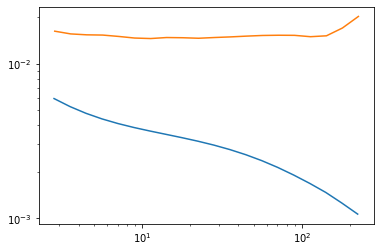

In [46]:
fig, ax = plt.subplots()

ax.loglog(theta, np.sqrt( cov.diagonal() ) )
ax.loglog( meanr, np.sqrt(cov_new.diagonal()))